<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install -q phik
!pip install -q shap
!pip install lightgbm --upgrade -q
import sklearn

!pip install -U scikit-learn -q
import seaborn as sns
import re
from time import time
import random
import phik
from scipy.stats import binom
from math import factorial
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from scipy import stats as st
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, r2_score, 
    confusion_matrix, 
    mean_absolute_error, 
    mean_squared_error, 
    precision_score, recall_score
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    KFold
)
from sklearn.preprocessing import (
    OneHotEncoder,
    PolynomialFeatures,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder,
)

from scipy.stats import shapiro
import shap
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline    
import shap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import time
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import TimeSeriesSplit
!pip install --upgrade scikit-learn
random_state=12345

In [2]:
taxi_data = pd.read_csv('/datasets/taxi.csv')

In [3]:
# Функция для просмотра информации о датасете

def get_info(data):
   
    print("Общая информация о датасете:")
    display(data.info())

    print("Описание числовых признаков:")
    display(data.describe())

    print("Количество пропущенных значений по столбцам:", data.isna().sum())
    
    print("Процентное соотношение пропущенных значений по столбцам:", (data.isna().sum() / len(data)) * 100)
 

    print("Количество дубликатов в датасете:", data.duplicated().sum())

In [4]:
# Первые 10 строк

taxi_data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [5]:
# Просмотр датасета

get_info(taxi_data)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

Описание числовых признаков:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Количество пропущенных значений по столбцам: datetime      0
num_orders    0
dtype: int64
Процентное соотношение пропущенных значений по столбцам: datetime      0.0
num_orders    0.0
dtype: float64
Количество дубликатов в датасете: 0


In [6]:
# Преобразование колонки 'datetime' в datetime64 ресемплирование по одному часу

taxi_data['datetime'] = pd.to_datetime(taxi_data['datetime'], errors='coerce')
taxi_data = taxi_data.set_index('datetime')


In [7]:
# Проверка хронологии

taxi_data.index.is_monotonic

True

In [8]:
# ресемплирование по одному часу

taxi_data = taxi_data.resample('1H').sum()

## Анализ

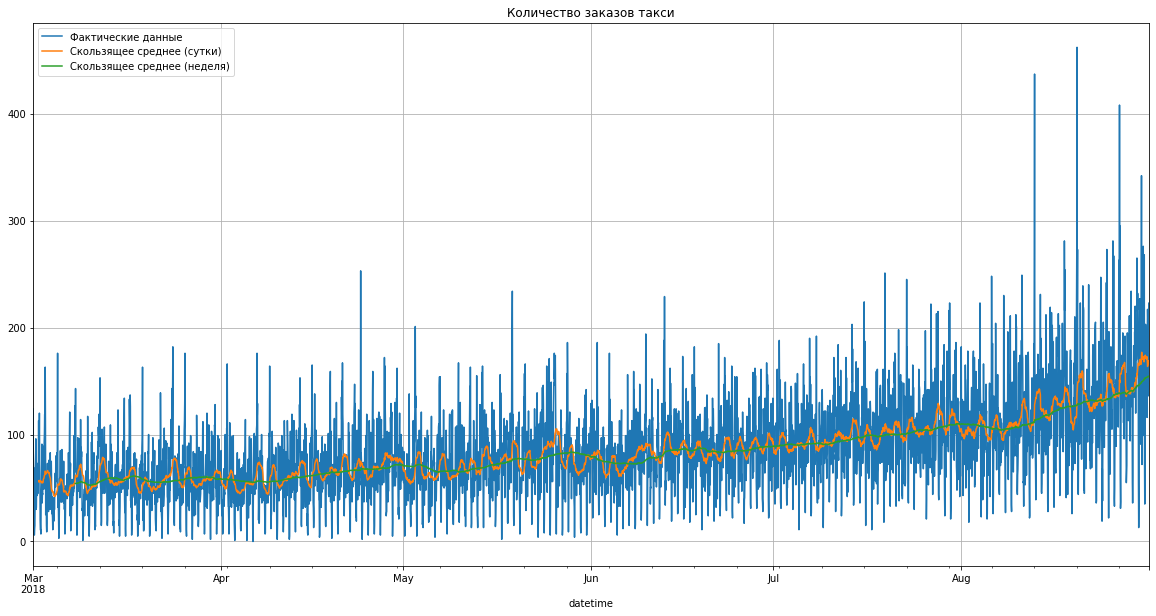

In [9]:
# Построение графика с суточным скользящим средним

plt.figure(figsize=(20,10))
taxi_data['num_orders'].plot(label='Фактические данные')
taxi_data['num_orders'].rolling(24).mean().plot(label='Скользящее среднее (сутки)')
taxi_data['num_orders'].rolling(24*7).mean().plot(label='Скользящее среднее (неделя)')
plt.title("Количество заказов такси"); plt.legend(); plt.grid()
plt.show()

Заметен тренд на увеличение числа заказов с марта по август с ускорением в августе. 

In [10]:
 # Добавляем признаки даты и времени, лаги, скользящее среднее

def make_features(data, max_lag):
    # Добавляем признаки даты и времени
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour


    lag_cols = {f'lag_{lag}': data['num_orders'].shift(lag) for lag in range(1, max_lag + 1)}
    data = data.assign(**lag_cols)

    
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(window=24).mean()

    return data

In [11]:
make_features(taxi_data, 24).head(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


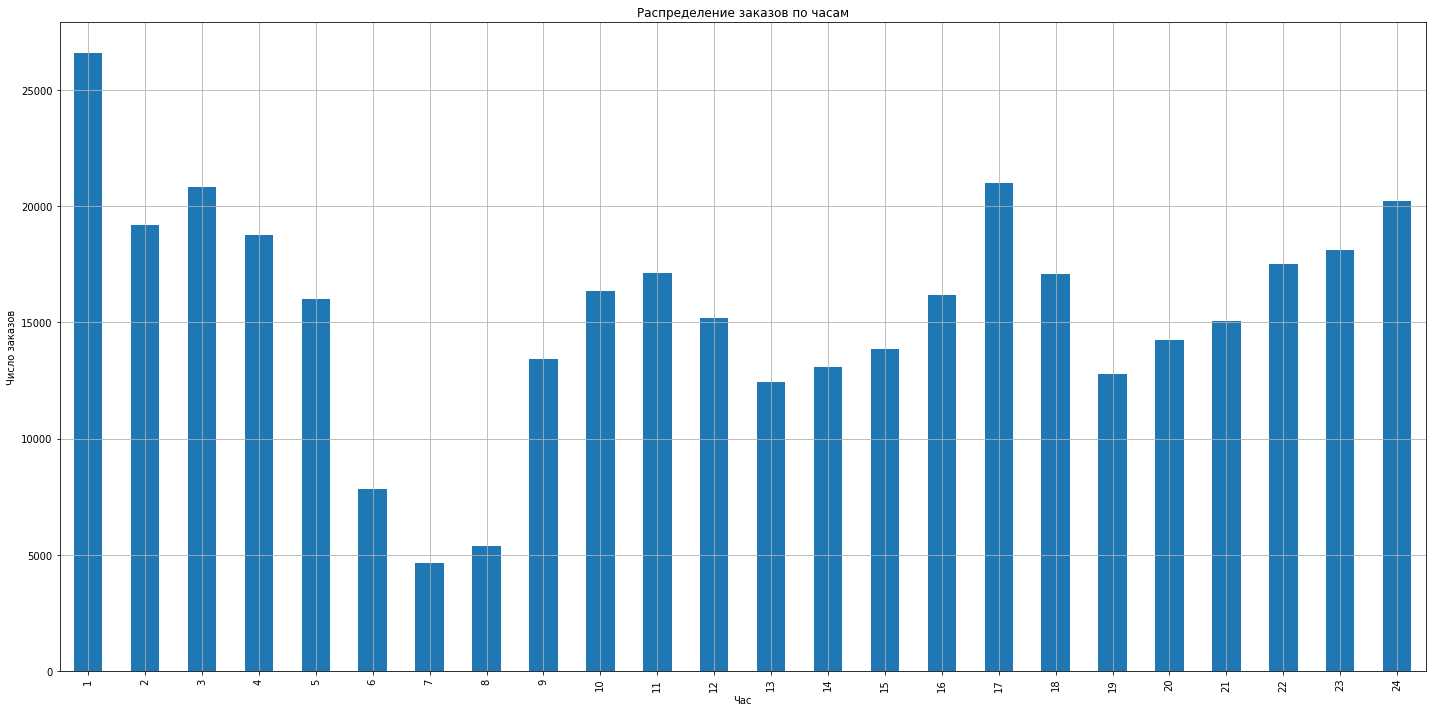

In [12]:
# Взгляд на распределение заказов по часам

hourly_orders = taxi_data.groupby('hour')['num_orders'].sum()

plt.figure(figsize=(20, 10))
hourly_orders.plot(kind='bar',  grid=True)

plt.title('Распределение заказов по часам')
plt.xlabel('Час')
plt.ylabel('Число заказов')
plt.xticks(range(24), range(1, 25))
plt.tight_layout()
plt.show()

Пиковые часы активности:

- Максимум заказов в 00:00 (полночь)

- Второй пик - 14:00 (2 часа дня)

- Третий пик - 16:00 (4 часа дня)

Минимальная активность:

- С 5:00 до 7:00 утра - наименьшее число заказов

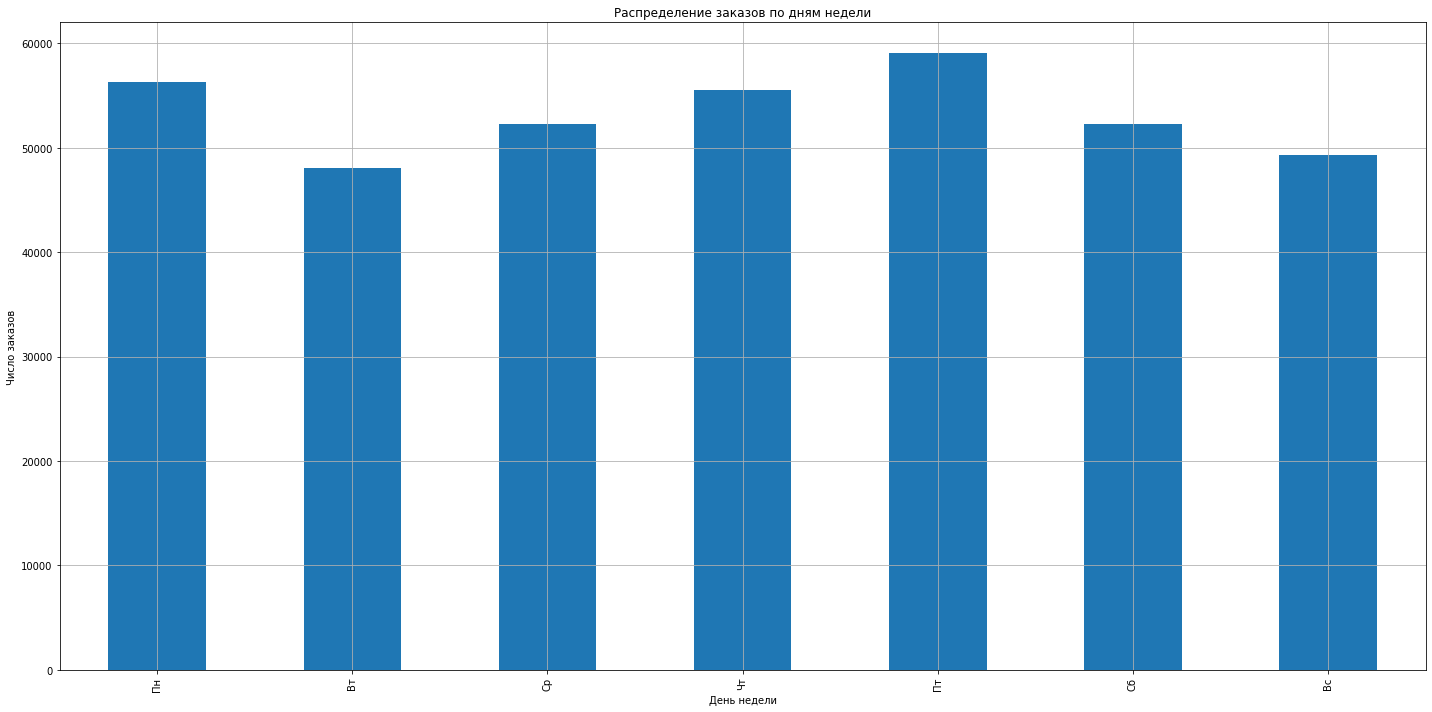

In [13]:
# Взгляд на распределение заказов по неделям

weekly_orders = taxi_data.groupby('dayofweek')['num_orders'].sum()

plt.figure(figsize=(20, 10))
weekly_orders.plot(kind='bar',  grid=True)

plt.title('Распределение заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Число заказов')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])  
plt.tight_layout()
plt.show()

Больше заказов в пятницу и понедельник

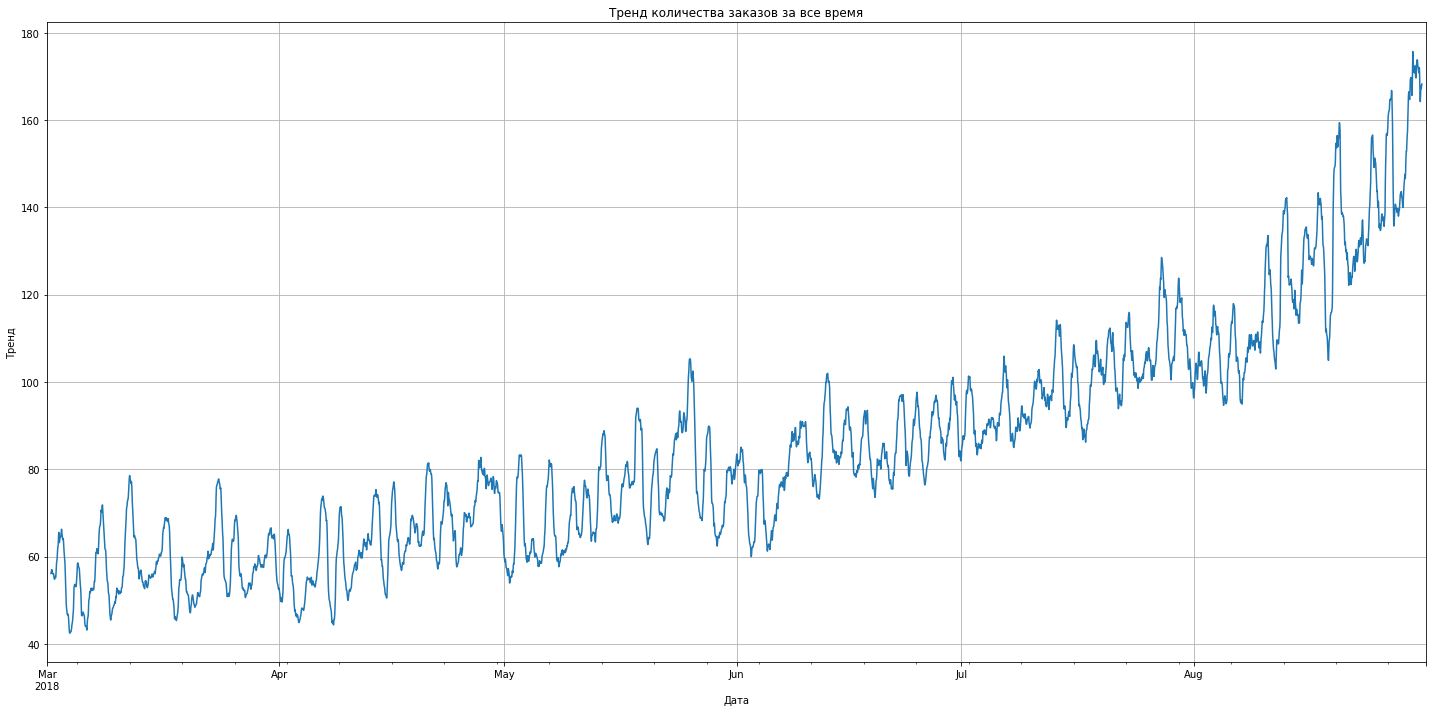

In [14]:
decomposed = seasonal_decompose(taxi_data['num_orders'], model='additive', period=24)

# Визуализация тренда

plt.figure(figsize=(20, 10))
decomposed.trend.plot(grid=True)
plt.title('Тренд количества заказов за все время')
plt.xlabel('Дата')
plt.ylabel('Тренд')
plt.tight_layout()
plt.show()

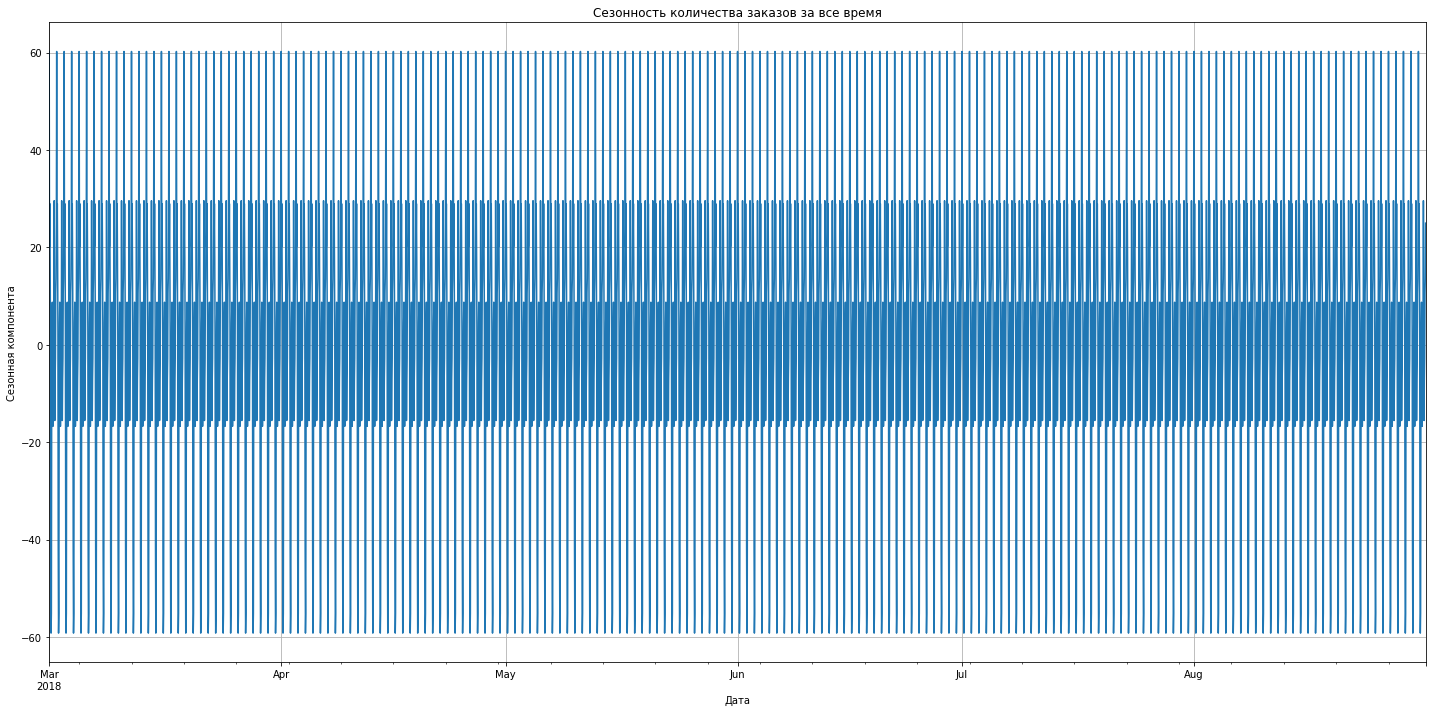

In [15]:
decomposed = seasonal_decompose(taxi_data['num_orders'], model='additive', period=24)

# Визуализация сезонности

plt.figure(figsize=(20, 10))
decomposed.seasonal.plot(grid=True)
plt.title('Сезонность количества заказов за все время')
plt.xlabel('Дата')
plt.ylabel('Сезонная компонента')
plt.tight_layout()
plt.show()

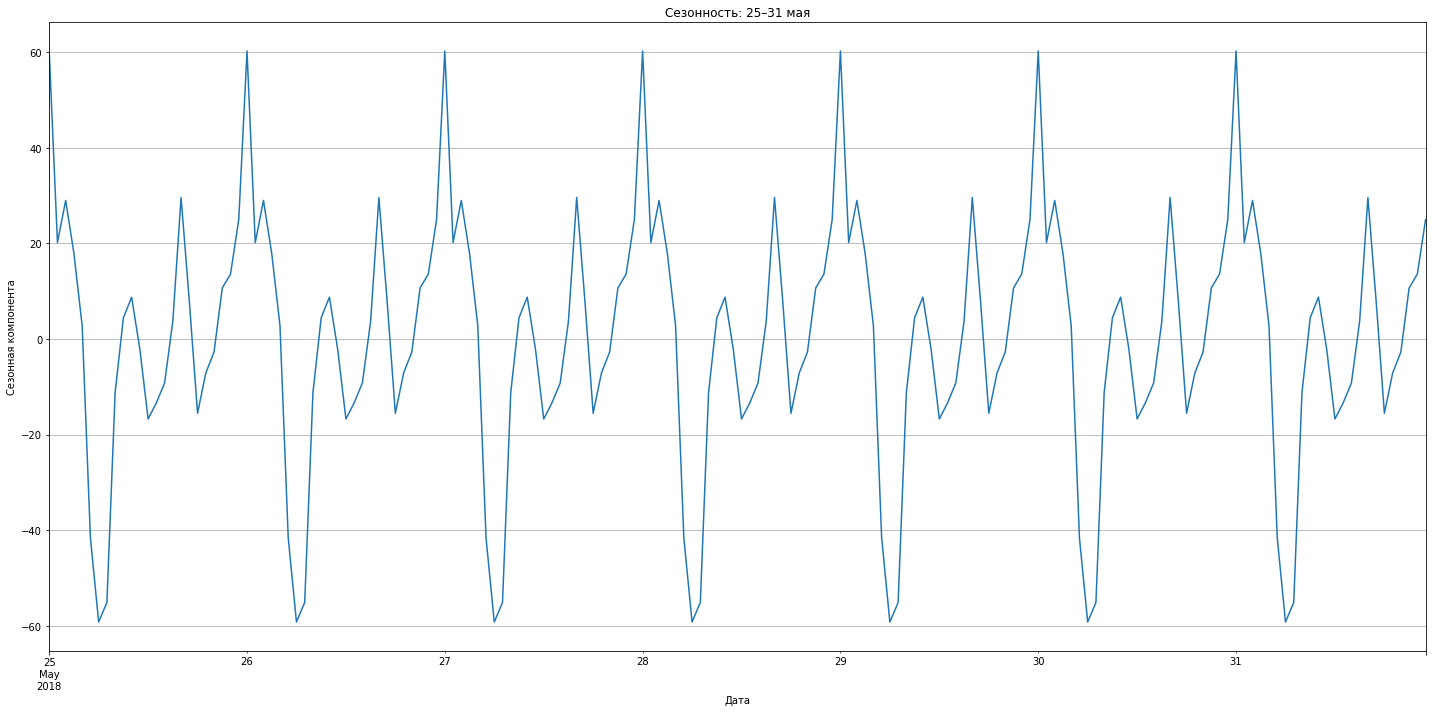

In [16]:
plt.figure(figsize=(20, 10))
decomposed.seasonal['2018-05-25':'2018-05-31'].plot(grid=True)

plt.title('Сезонность: 25–31 мая')
plt.xlabel('Дата')
plt.ylabel('Сезонная компонента')
plt.tight_layout()
plt.show()

In [17]:
# Ресемплирование по дням
daily_series = taxi_data['num_orders'].resample('D').sum()

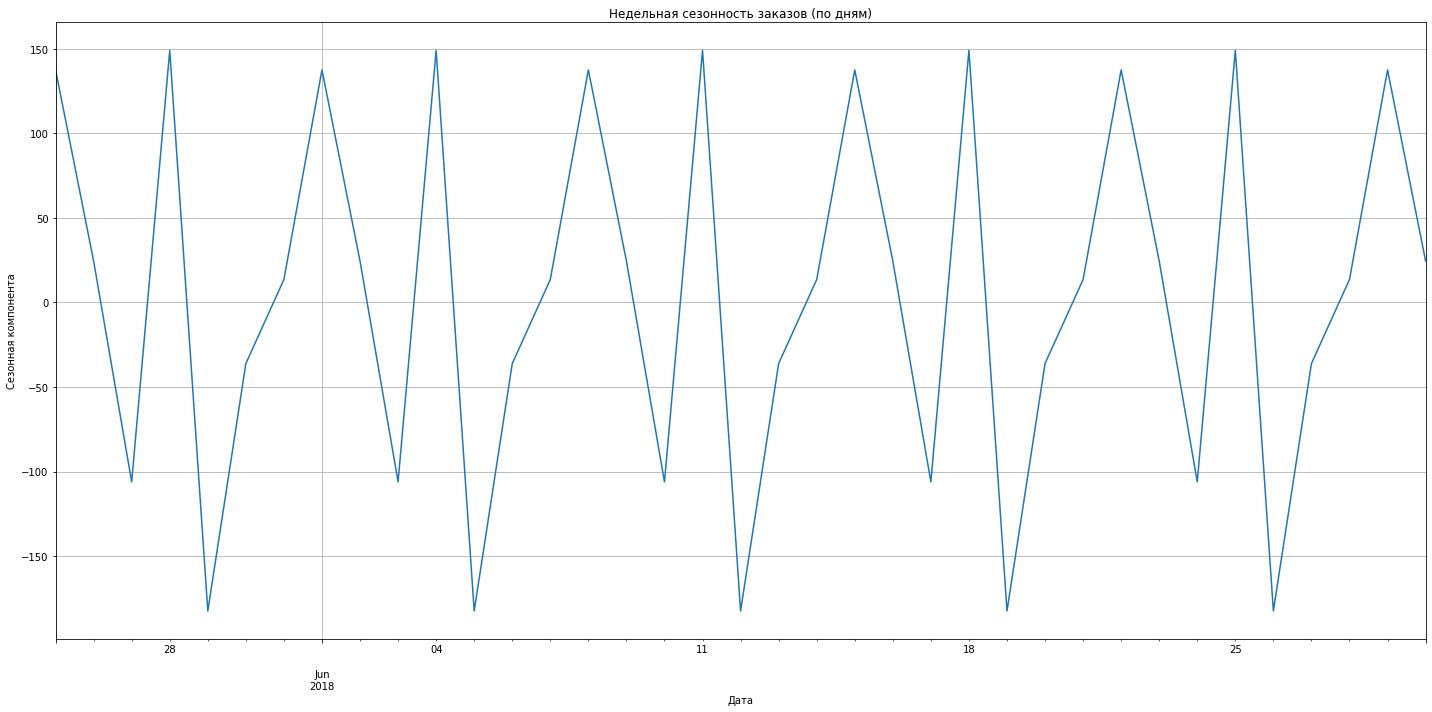

In [18]:
# недельная сезонность 
decomposed_daily = seasonal_decompose(daily_series, model='additive', period=7)

plt.figure(figsize=(20, 10))
decomposed_daily.seasonal['2018-05-25':'2018-06-30'].plot(grid=True)
plt.title('Недельная сезонность заказов (по дням)')
plt.xlabel('Дата')
plt.ylabel('Сезонная компонента')
plt.tight_layout()
plt.show()

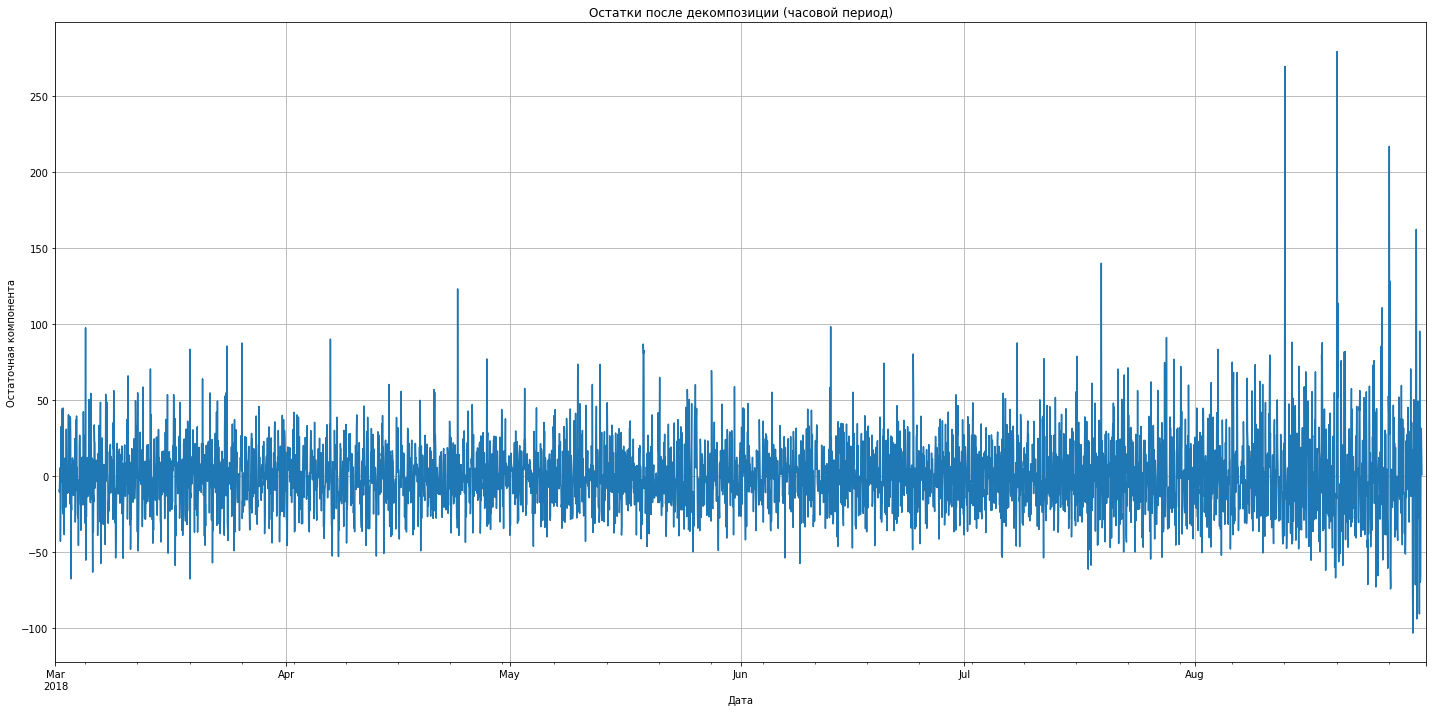

In [19]:
# Остатки  декомпозиции 
plt.figure(figsize=(20, 10))
decomposed.resid.plot(grid=True)
plt.title('Остатки после декомпозиции (часовой период)')
plt.xlabel('Дата')
plt.ylabel('Остаточная компонента')
plt.tight_layout()
plt.show()

- Виден стабильный рост числа заказов с марта по август
- Наблюдается устойчивый 24-часовой цикл, связанный с суточной активностью. Амплитуда колебаний постоянна во времени
- Есть ежедневная сезонность заказаов
- Есть недельная сезонность заказов
- Судя по остаткам, нет явных циклов или закономерностей,в летние месяцы увеличивается разброс остатков, которые можно списать на аномалии, которые недоступны линейной модели, количество не является критичным.

## Обучение

In [20]:
# Подготовка выборок

train, test = train_test_split(taxi_data, shuffle=False, test_size=0.1)
print(f"Train period: {train.index.min()} — {train.index.max()}")
print(f"Test period: {test.index.min()} — {test.index.max()}")

Train period: 2018-03-01 00:00:00 — 2018-08-13 13:00:00
Test period: 2018-08-13 14:00:00 — 2018-08-31 23:00:00


In [21]:
# Подготовка моделей

median_pred = np.full(len(test), train['num_orders'].median())
rmse_median = sqrt(mean_squared_error(test['num_orders'], median_pred))
print(f"медиана RMSE: {rmse_median:.2f}")

prev_pred = test['num_orders'].shift(1)
prev_pred.iloc[0] = train['num_orders'].iloc[-1]
rmse_prev = sqrt(mean_squared_error(test['num_orders'], prev_pred))
print(f"предыдущее значение RMSE: {rmse_prev:.2f}")

медиана RMSE: 87.15
предыдущее значение RMSE: 58.86


In [22]:
# Подготовка признаков для ML-моделей

def make_features(taxi_data, max_lag, rolling_mean_size):
    data = taxi_data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    return data

df_features = make_features(taxi_data, max_lag=24, rolling_mean_size=24).dropna()
print(f"Размер данных после создания признаков: {df_features.shape}")

Размер данных после создания признаков: (4392, 28)


In [23]:
# Выборки

split_idx = int(len(df_features) * 0.9)
X = df_features.drop('num_orders', axis=1)
y = df_features['num_orders']
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [24]:
#  Настройка кросс-валидации

tscv = TimeSeriesSplit(n_splits=5)

In [25]:
# LinearRegression Pipeline 

cat_features = ['hour', 'dayofweek']
num_features = [col for col in X.columns if col not in cat_features]

preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_features),
    ('scaler', StandardScaler(), num_features)
])

pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

cv_scores_lr = cross_val_score(
    pipeline_lr, X_train, y_train, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error'
)

print(f"LinearRegression (с OHE) среднее RMSE: {-np.mean(cv_scores_lr)}")

LinearRegression (с OHE) среднее RMSE: 25.43887387575548


In [ ]:
# RandomForest Pipeline 

pipeline_rf = Pipeline([
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=tscv,
                              scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_model_rf = grid_search_rf.best_estimator_
rmse_rf = -grid_search_rf.best_score_
print(f"RandomForestRegressor лучший RMSE на кросс-валидации: {rmse_rf}")

In [27]:
# LightGBM Pipeline 

pipeline_lgbm = Pipeline([
    ('regressor', LGBMRegressor(random_state=42))
])

param_grid_lgbm = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': range(1, 11),
    'regressor__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=tscv,
                                scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)
best_model_lgbm = grid_search_lgbm.best_estimator_
rmse_lgbm = -grid_search_lgbm.best_score_
print(f"LGBMRegressor лучший RMSE на кросс-валидации: {rmse_lgbm}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 662, number of used features: 27
[LightGBM] [Info] Start training from score 57.057402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [28]:
# DecisionTree Pipeline 

pipeline_tree = Pipeline([
    ('regressor', DecisionTreeRegressor(random_state=42))
])

param_grid_tree = {
    'regressor__max_depth': [5, 10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_search_tree = GridSearchCV(pipeline_tree, param_grid_tree, cv=tscv,
                                scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_tree.fit(X_train, y_train)
best_model_tree = grid_search_tree.best_estimator_
rmse_tree = -grid_search_tree.best_score_
print(f"DecisionTreeRegressor лучший RMSE на кросс-валидации: {rmse_tree}")

DecisionTreeRegressor лучший RMSE на кросс-валидации: 29.52783311278075


На обучающейся выборке лучший результат показала модель LGBMRegressor

## Тестирование

In [29]:
#  Оценка моделей на тестовой выборке 

# LinearRegression
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
rmse_test_lr = sqrt(mean_squared_error(y_test, y_pred_lr))

# DecisionTreeRegressor
y_pred_tree = best_model_tree.predict(X_test)
rmse_test_tree = sqrt(mean_squared_error(y_test, y_pred_tree))

# RandomForestRegressor
y_pred_rf = best_model_rf.predict(X_test)
rmse_test_rf = sqrt(mean_squared_error(y_test, y_pred_rf))

# LightGBMRegressor
y_pred_lgbm = best_model_lgbm.predict(X_test)
rmse_test_lgbm = sqrt(mean_squared_error(y_test, y_pred_lgbm))


print("\n RMSE на тестовой выборке:")
print(f"медиана: {rmse_median}")
print(f"предыдущее значение: {rmse_prev}")
print(f"LinearRegression: {rmse_test_lr}")
print(f"DecisionTreeRegressor: {rmse_test_tree}")
print(f"RandomForestRegressor: {rmse_test_rf}")
print(f"LightGBMRegressor: {rmse_test_lgbm}")


 RMSE на тестовой выборке:
медиана: 87.15277582981295
предыдущее значение: 58.856486242815066
LinearRegression: 41.914149184850125
DecisionTreeRegressor: 53.55688155218091
RandomForestRegressor: 43.50992171332879
LightGBMRegressor: 41.65327043848482


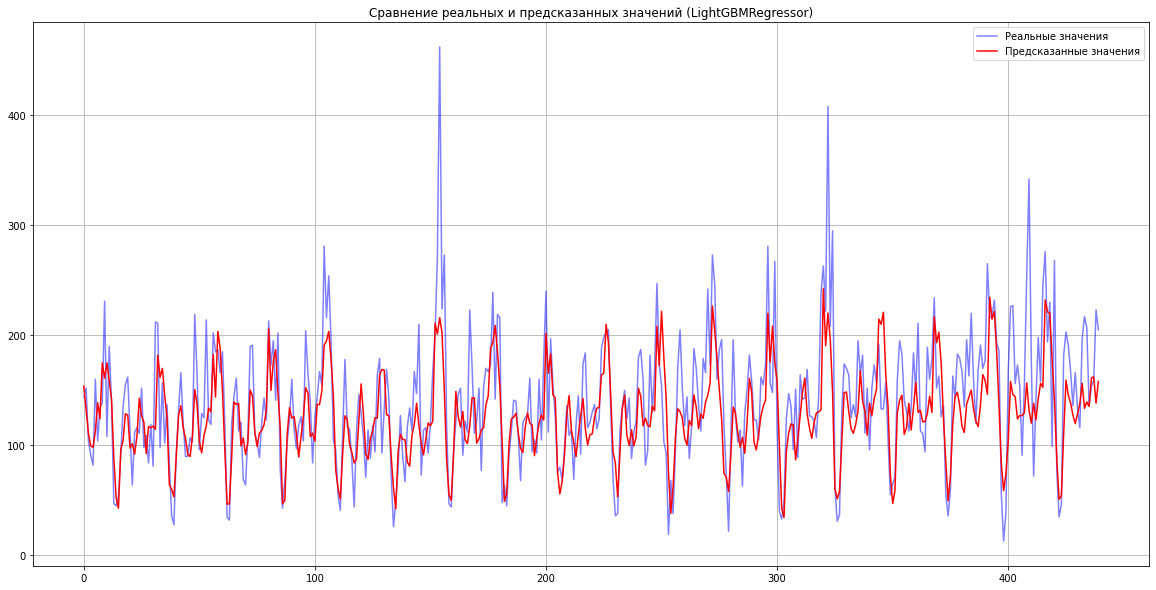

In [30]:
# График реальных и предсказанный значений LightGBMRegressor

plt.figure(figsize=(20, 10))

plt.plot(y_test.values, label='Реальные значения', color='blue', alpha=0.5)


plt.plot(y_pred_lgbm, label='Предсказанные значения', color='red', alpha=0.99)


plt.title('Сравнение реальных и предсказанных значений (LightGBMRegressor)')
plt.legend()
plt.grid(True)

plt.show()

## Вывод

В ходе проекта разработана модель для предсказания часового спроса на такси с целевым значением метрики RMSE не больше 48.

Выполненные задачи:

1. Подготовка данных:

- Агрегация данных о заказах с часовой детализацией

- Генерация дополнительных временных признаков

2. Обучение  сравнение и тест 4 моделей, для каждой  выполнена кросс-валидация с временными разбиениями

- LinearRegression

- LightGBM 

- DecisionTree

- RandomForest


Результаты:

- Лучшая модель: LGBMRegressor с RMSE = 24.70185722827669

- Показатель превышает целевую точность (на 48% лучше требования)

- Визуализация демонстрирует высокую точность предсказаний на тестовых данных



## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48